## Step 1 — Load All Scraped CSV Files

Load all files from carData/, concatenate them into one DataFrame, and preview the combined dataset.

In [46]:
import pandas as pd
import glob

# Load all brand-specific CSVs
csv_files = glob.glob("../carData/*.csv")

print("Files found:", len(csv_files))
for f in csv_files:
    print("  •", f)

# Merge into a single DataFrame
df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

print("Dataset shape:", df.shape)
df.sample(6)

Files found: 24
  • ../carData\cars_audi.csv
  • ../carData\cars_bmw.csv
  • ../carData\cars_chevrolet.csv
  • ../carData\cars_citroen.csv
  • ../carData\cars_dacia.csv
  • ../carData\cars_fiat.csv
  • ../carData\cars_ford.csv
  • ../carData\cars_honda.csv
  • ../carData\cars_hyundai.csv
  • ../carData\cars_kia.csv
  • ../carData\cars_mazda.csv
  • ../carData\cars_mercedes-benz.csv
  • ../carData\cars_mitsubishi.csv
  • ../carData\cars_nissan.csv
  • ../carData\cars_opel.csv
  • ../carData\cars_peugeot.csv
  • ../carData\cars_renault.csv
  • ../carData\cars_seat.csv
  • ../carData\cars_skoda.csv
  • ../carData\cars_suzuki.csv
  • ../carData\cars_tesla.csv
  • ../carData\cars_toyota.csv
  • ../carData\cars_volkswagen.csv
  • ../carData\cars_volvo.csv
Dataset shape: (11921, 12)


,marca,model,pret,capacitate motor,putere,combustibil,caroserie,rulaj,culoare,an fabricatie,cutie viteza,descriere
7135,nissan,Juke,4 799 €,1 499 cm³,110 CP,Diesel,Hatchback,241 000 km,Negru,2012.0,Manuala,"Vand Nissan juke 1,5 dci 110cp\nImport Germani..."
4759,hyundai,ix35,8 850 €,1 685 cm³,115 CP,Diesel,SUV,231 000 km,Negru,2015.0,Manuala,Hyundai ix35 1.7 CRDi.RATE cu AVANS 0!Garantie...
3399,fiat,Panda,4 000 €,875 cm³,85 CP,Benzina,Hatchback,192 000 km,Albastru,2013.0,Manuala,192 000 km - fabricatie 2013 luna 11\nMotor be...
7883,peugeot,308,4 999 €,1 600 cm³,100 CP,Diesel,Break,135 000 km,Gri,2015.0,Manuala,Peugeot 308 SW\n-stare foarte buna\n-consum re...
8203,peugeot,207,3 500 €,1 400 cm³,68 CP,Diesel,Hatchback,134 000 km,Gri,2011.0,Manuala,Peugeot 207 1.4hdi an fabricatie 2011 stare de...
11644,volvo,XC 60,13 490 €,1 998 cm³,150 CP,Diesel,SUV,230 000 km,Gri,2015.0,Automata,VOLVO XC60 2.0 DIESEL 150 CP\nTRANSPORT LA DOM...


## 🧹 Step 2 — Clean and prepare the dataset

Goals:

Convert text fields into numeric values

price → "10 500 €" → 10500.0

capacitate motor → "1 995 cm³" → 1995

putere → "184 CP" → 184

rulaj → "280 000 km" → 280000

an fabricatie → "2012" → 2012

Drop the descriere column (not useful for the training of the model).

Remove rows where key numeric fields are missing.

Store in a copy of the data frame to keep the original safe

In [47]:
import numpy as np

# Create copy
df_clean = df.copy()

# --- Clean price: remove non-digits (€, spaces, lei) and convert to float
df_clean['pret'] = (
    df_clean['pret']
      .astype(str)
      .str.replace(r'[^\d]', '', regex=True)    # keep only digits
      .replace('', np.nan)                      # empty -> NaN
      .astype(float)
)

# --- Clean engine capacity: "1 995 cm³" -> 1995
df_clean['capacitate motor'] = (
    df_clean['capacitate motor']
      .astype(str)
      .str.replace(' ', '', regex=False)        # remove spaces
      .str.extract(r'(\d+)')      # first number sequence
      .astype(float)
)

# --- Clean power: "184 CP" -> 184
df_clean['putere'] = (
    df_clean['putere']
      .astype(str)
      .str.extract(r'(\d+)', expand=False)
      .astype(float)
)

# --- Clean mileage: "280 000 km" -> 280000
df_clean['rulaj'] = (
    df_clean['rulaj']
      .astype(str)
      .str.replace(' ', '', regex=False)
      .str.extract(r'(\d+)')      # take first numeric block
      .astype(float)
)

# --- Clean year: extract 4 digits
df_clean['an fabricatie'] = (
    df_clean['an fabricatie']
      .astype(str)
      .str.extract(r'(\d{4})', expand=False)
      .astype(float)
)

# Drop free-text description (not used in this version of the model)
if 'descriere' in df_clean.columns:
    df_clean = df_clean.drop(columns=['descriere'])

# Drop rows where key numeric fields are missing
key_numeric = ['pret', 'capacitate motor', 'putere', 'rulaj', 'an fabricatie']
df_clean = df_clean.dropna(subset=key_numeric)

# Convert numeric columns to int where it makes sense
for col in ['capacitate motor', 'putere', 'rulaj', 'an fabricatie']:
    df_clean[col] = df_clean[col].astype(int)

df_clean['pret'] = df_clean['pret'].astype(float)

df_clean = df_clean[
    (df_clean["pret"] < 80000) &
    (df_clean["pret"] > 1000)
]
df_clean = df_clean[
    (df_clean["rulaj"] < 600000) &
    (df_clean["rulaj"] > 1000)]
df_clean = df_clean[
    (df_clean["capacitate motor"] > 500) &
    (df_clean["capacitate motor"] < 6000)
]
df_clean = df_clean[
    (df_clean["putere"] < 600) &
    (df_clean["putere"] > 20)]

df_clean = df_clean[df_clean['an fabricatie'] > 1950]

print("Shape after cleaning:", df_clean.shape)
print("\nDtypes:")
print(df_clean.dtypes)

df_clean.head(-8)


Shape after cleaning: (9423, 11)

Dtypes:
marca                object
model                object
pret                float64
capacitate motor      int64
putere                int64
combustibil          object
caroserie            object
rulaj                 int64
culoare              object
an fabricatie         int64
cutie viteza         object
dtype: object


,marca,model,pret,capacitate motor,putere,combustibil,caroserie,rulaj,culoare,an fabricatie,cutie viteza
0,audi,A8,5800.0,3000,232,Diesel,Berlina,340000,Albastru,2007,Automata
1,audi,TT,6990.0,1998,170,Diesel,Coupe,245000,Negru,2009,Manuala
3,audi,A4,9900.0,1968,177,Diesel,Break,238200,Alb,2014,Automata
4,audi,A6,3490.0,1998,177,Diesel,Berlina,150000,Gri,2011,Manuala
5,audi,TT,8450.0,1968,170,Diesel,Coupe,238000,Albastru,2008,Manuala
...,...,...,...,...,...,...,...,...,...,...,...
11904,volvo,V40,6800.0,1969,120,Diesel,Hatchback,230000,Gri,2015,Manuala
11906,volvo,V40,5950.0,1560,115,Diesel,Hatchback,222294,Gri,2013,Manuala
11907,volvo,V60,14000.0,1969,150,Diesel,Break,233000,Alb,2019,Automata
11908,volvo,XC 40,20500.0,1996,150,Diesel,SUV,216000,Alb,2020,Manuala


## Step 3 - 📊 Exploratory Data Analysis (EDA)

This section provides visualizations to better understand the distribution and relationships inside the car dataset after scraping and cleaning.

STRUCTURE:



<class 'pandas.core.frame.DataFrame'>
Index: 9423 entries, 0 to 11920
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   marca             9423 non-null   object 
 1   model             9423 non-null   object 
 2   pret              9423 non-null   float64
 3   capacitate motor  9423 non-null   int64  
 4   putere            9423 non-null   int64  
 5   combustibil       9364 non-null   object 
 6   caroserie         9423 non-null   object 
 7   rulaj             9423 non-null   int64  
 8   culoare           8936 non-null   object 
 9   an fabricatie     9423 non-null   int64  
 10  cutie viteza      9238 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 883.4+ KB
None

MISSING VALUES:

marca                 0
model                 0
pret                  0
capacitate motor      0
putere                0
combustibil          59
caroserie             0
rulaj                 0
culoar

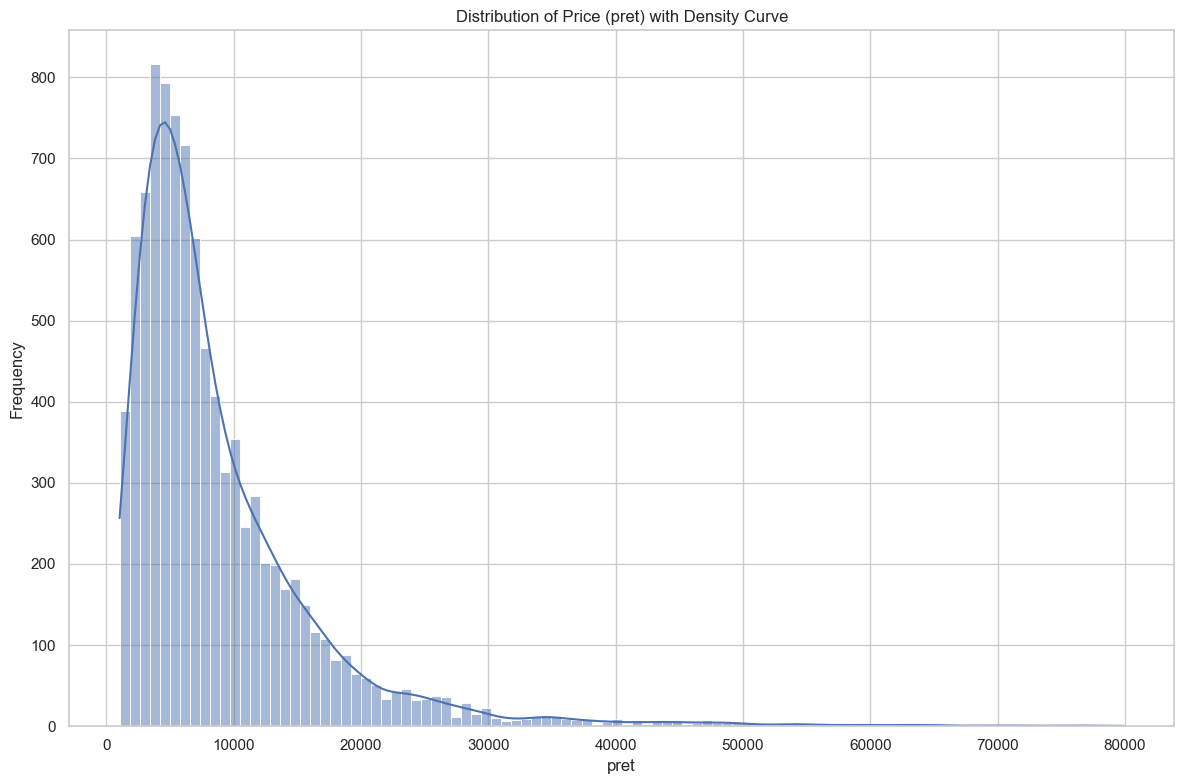

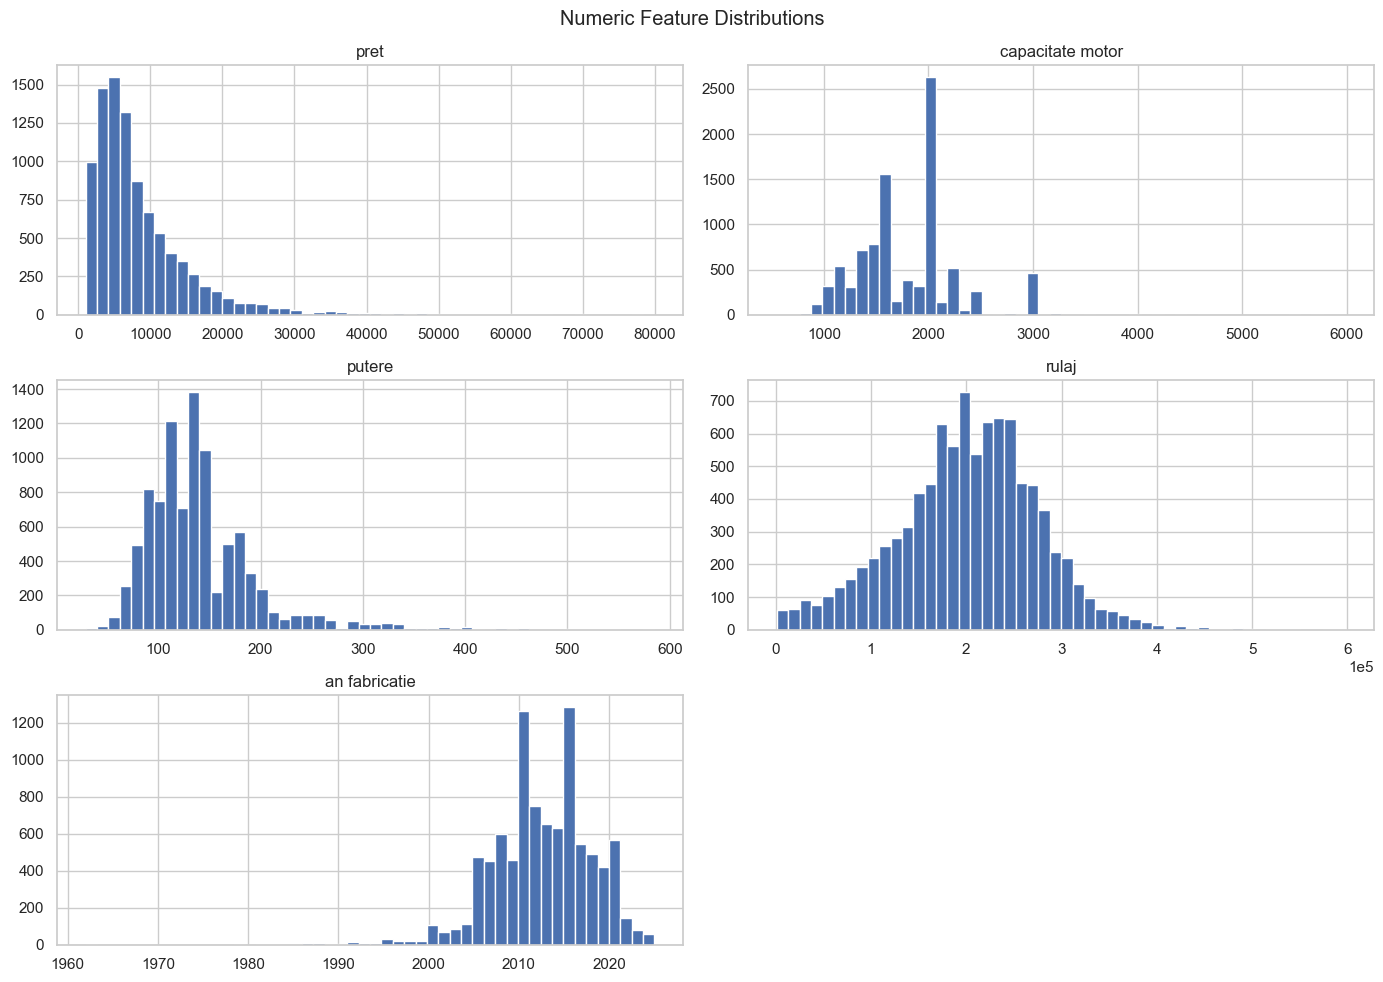

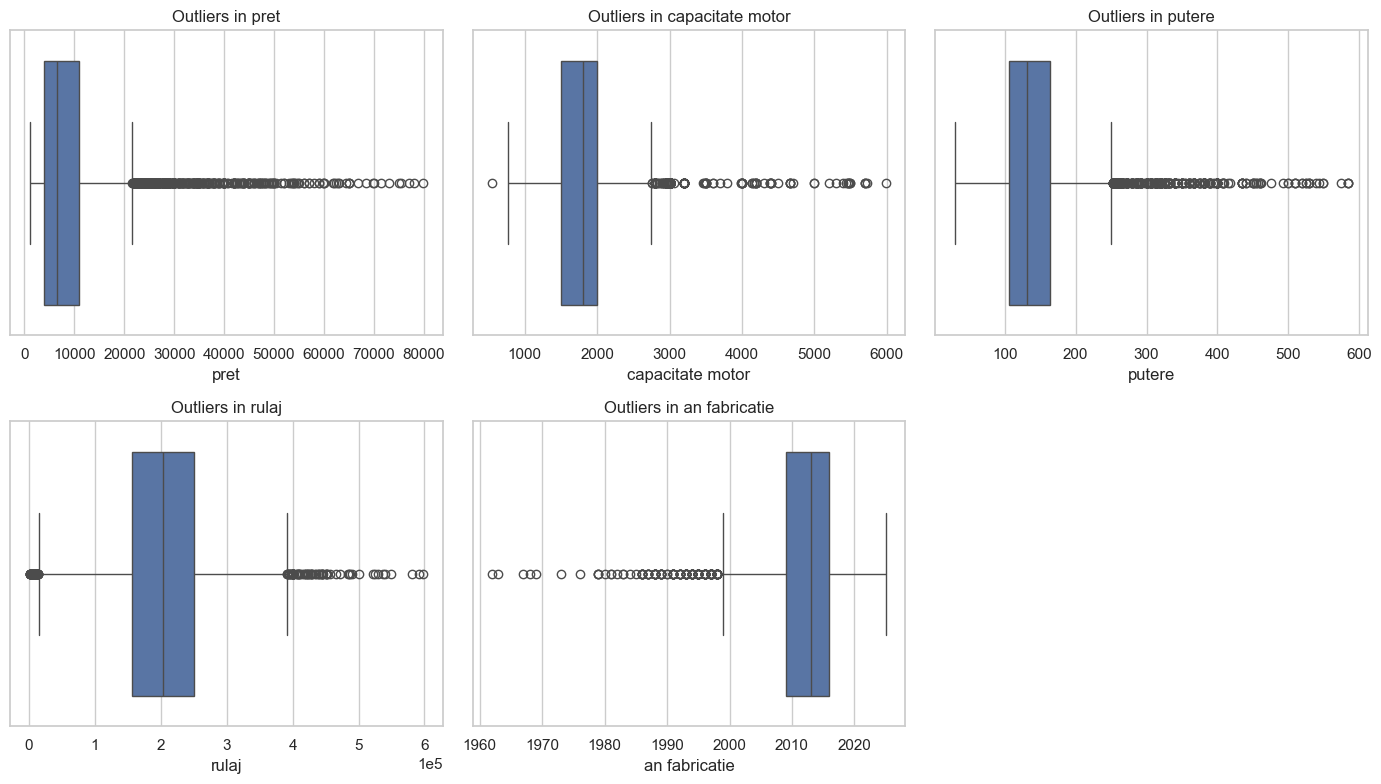

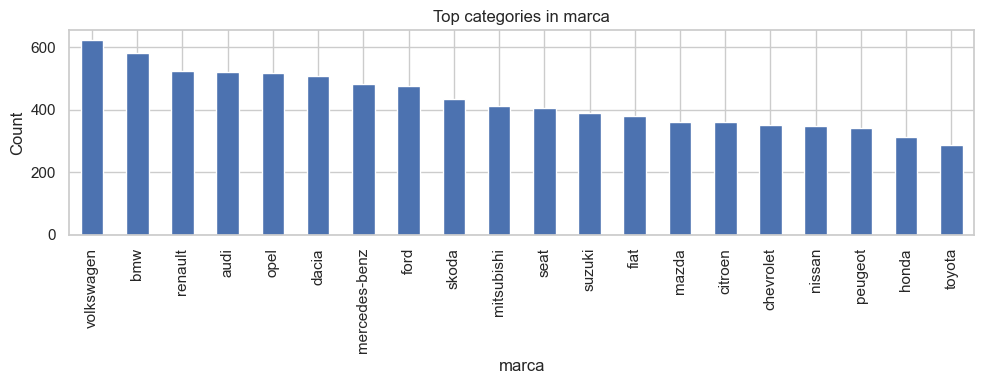

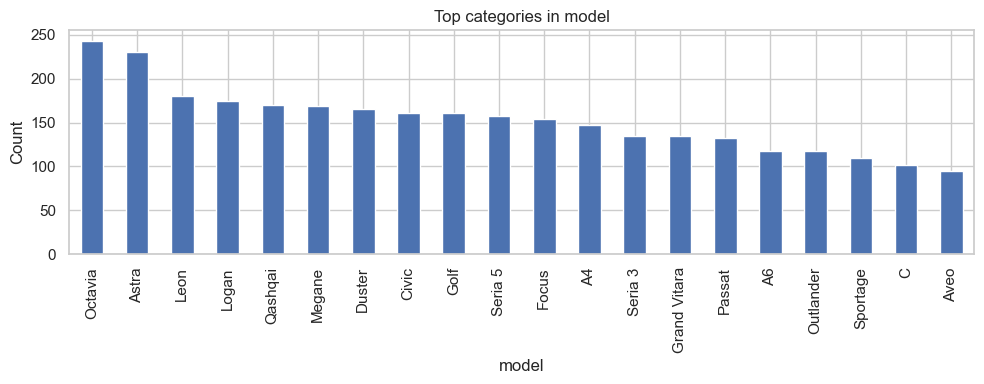

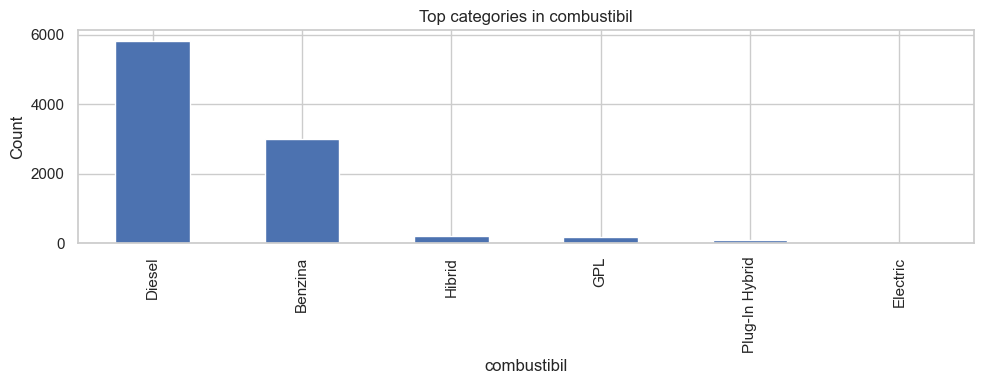

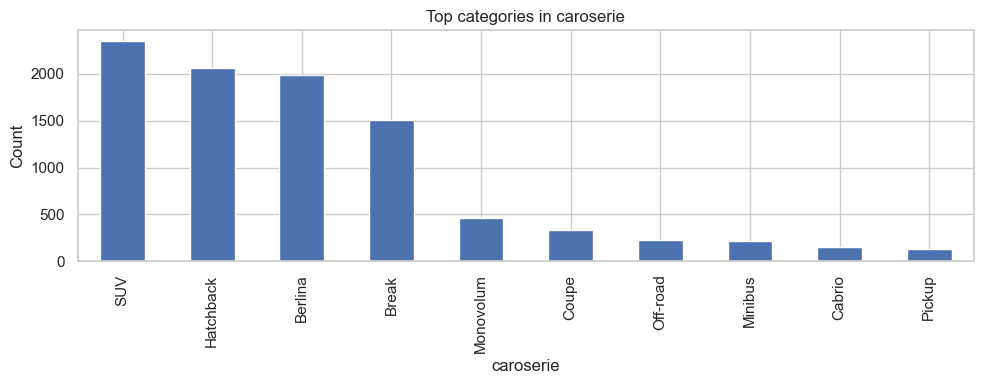

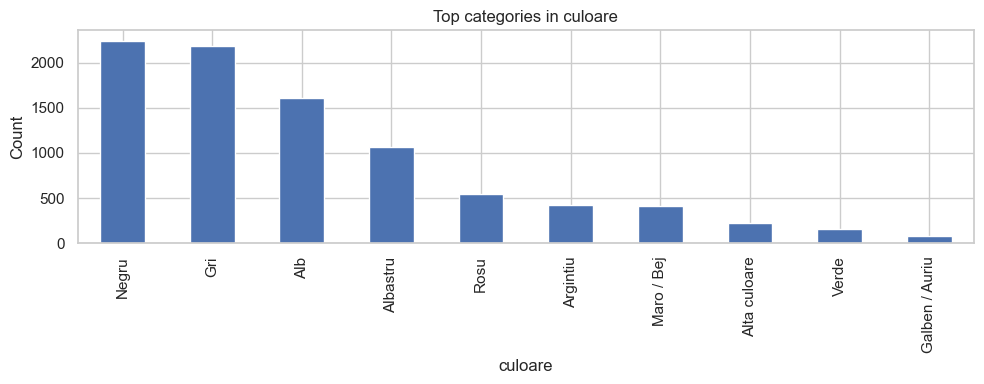

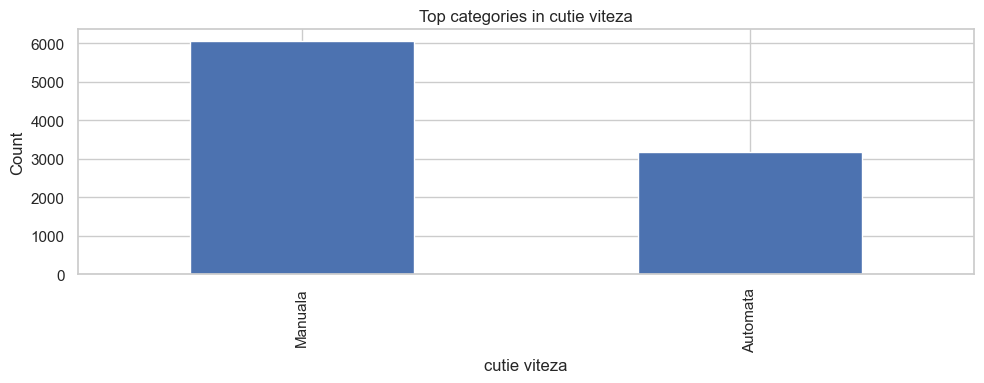

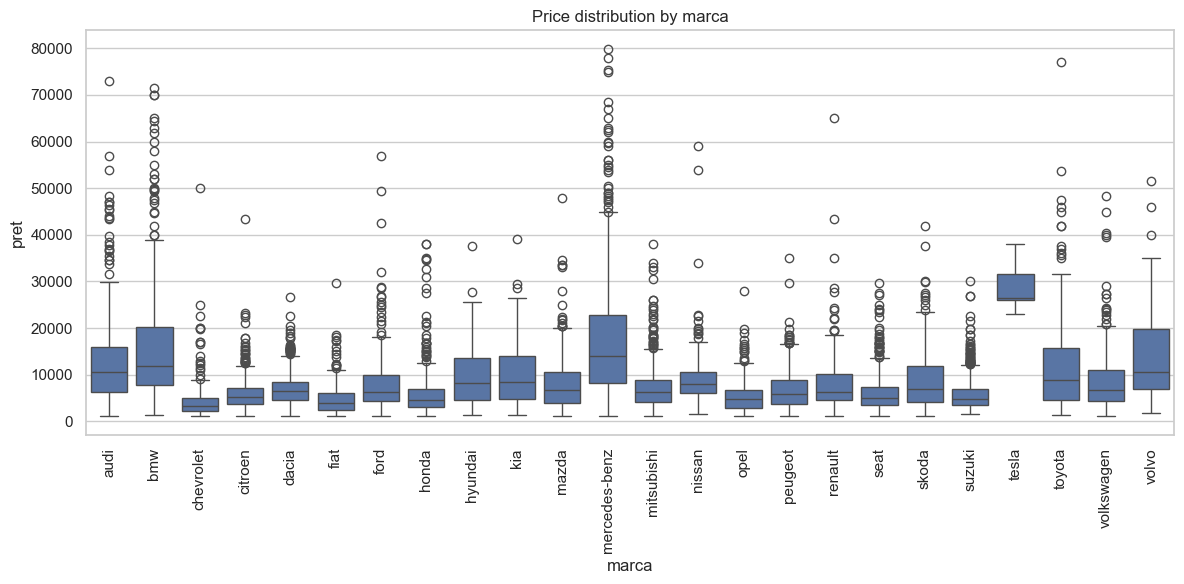

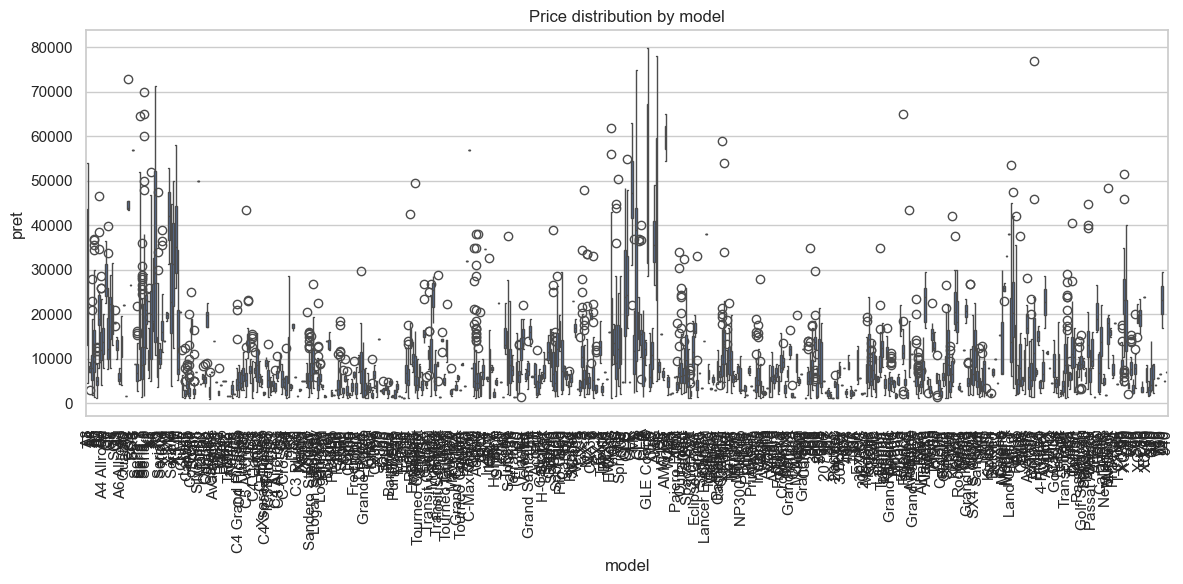

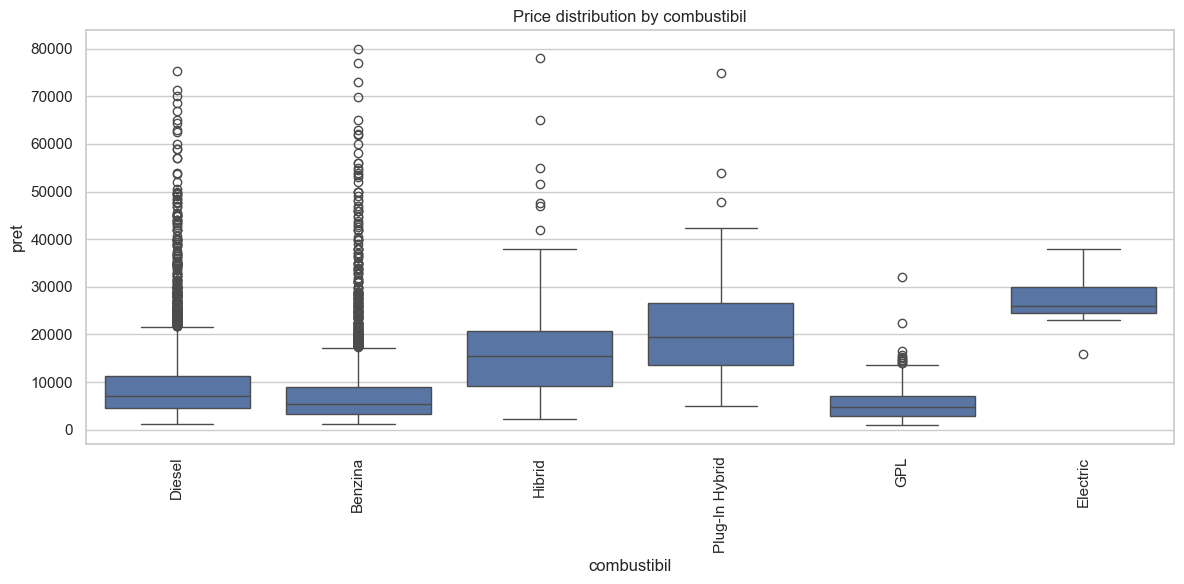

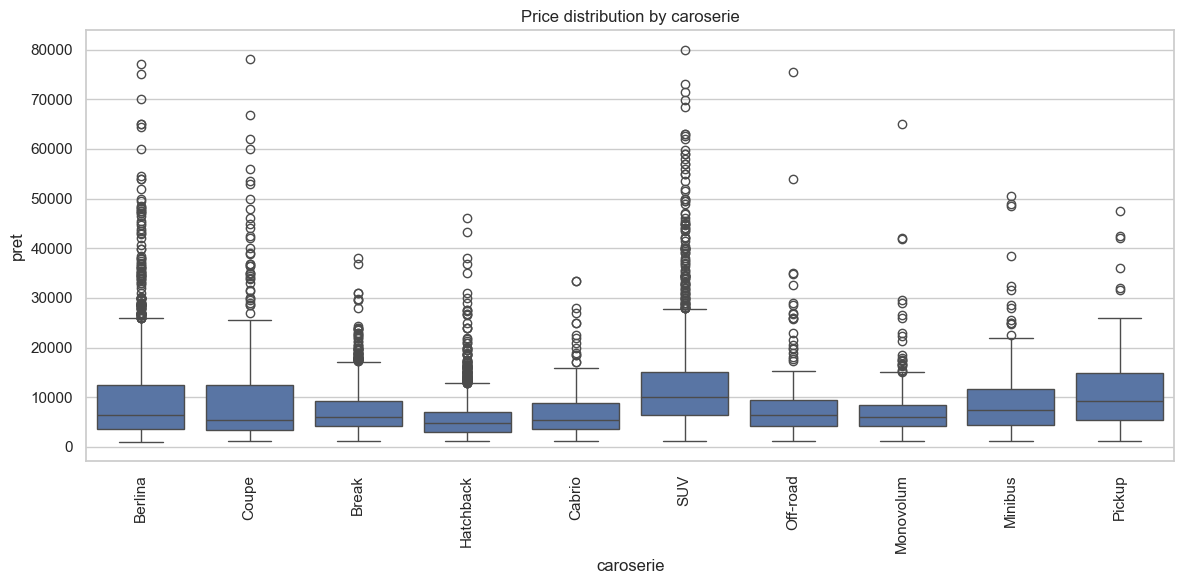

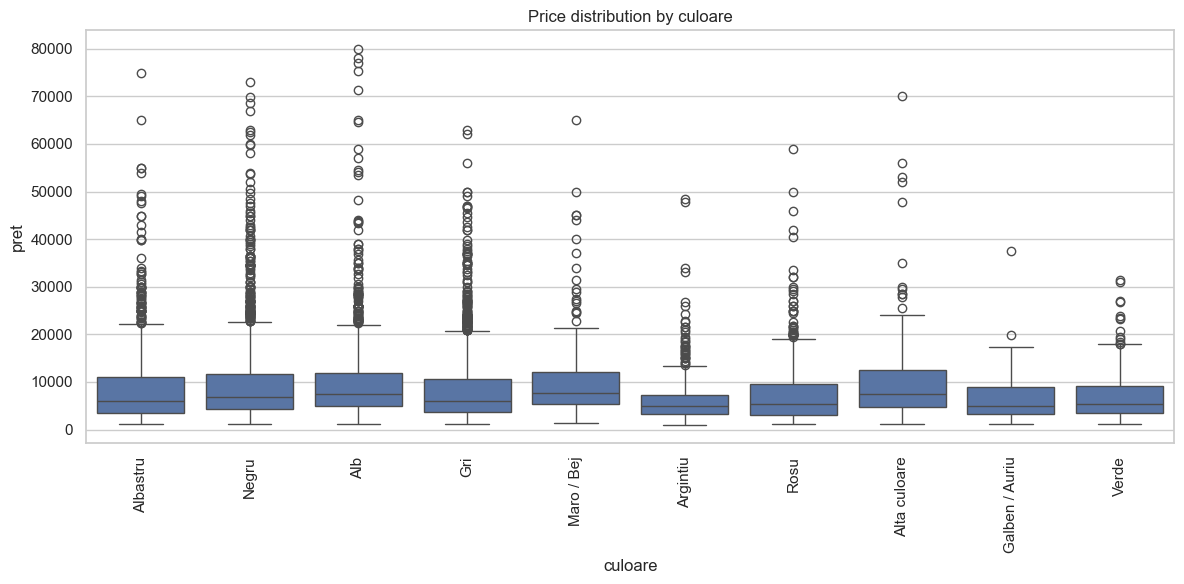

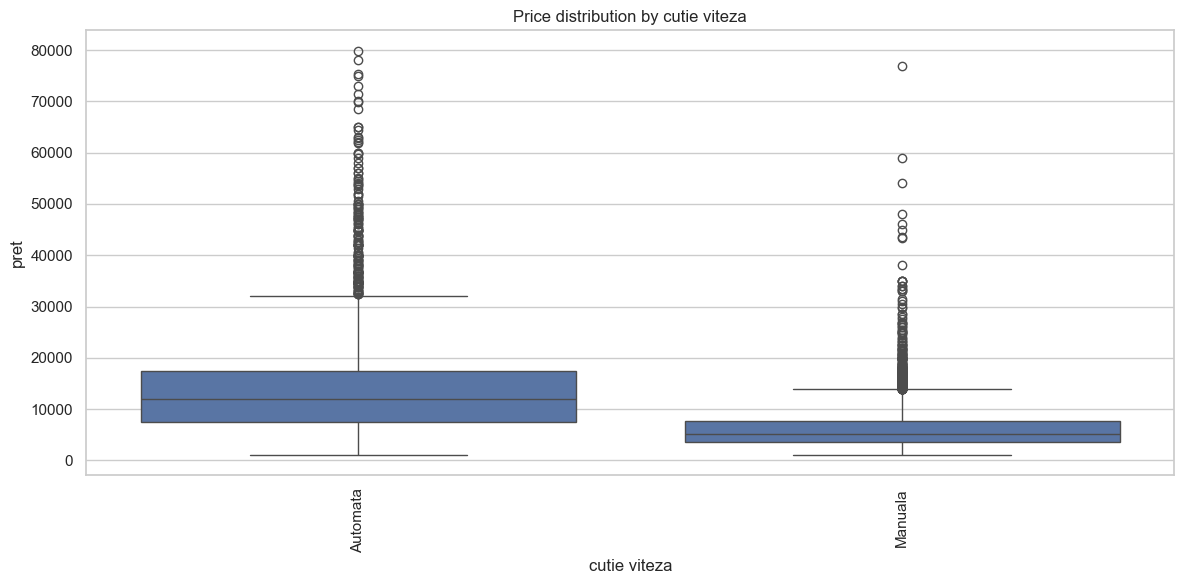

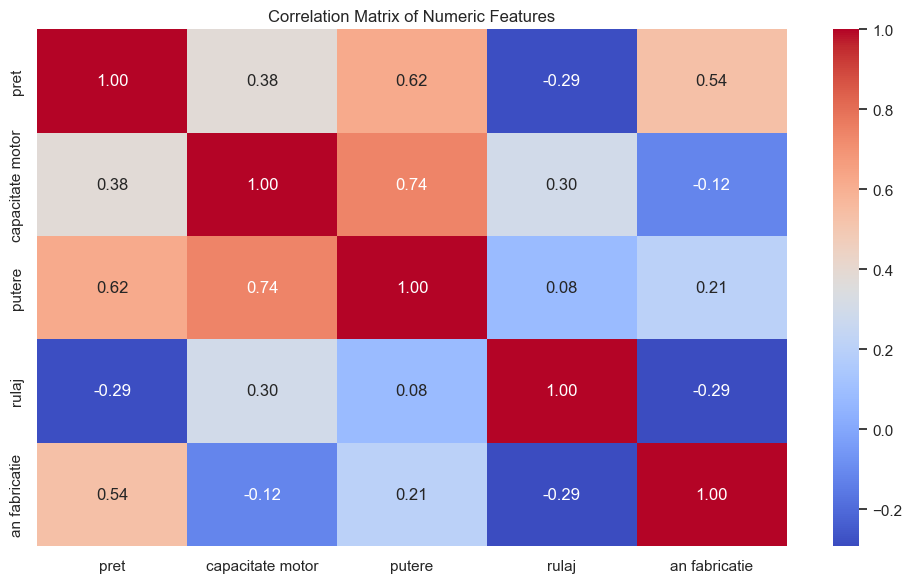

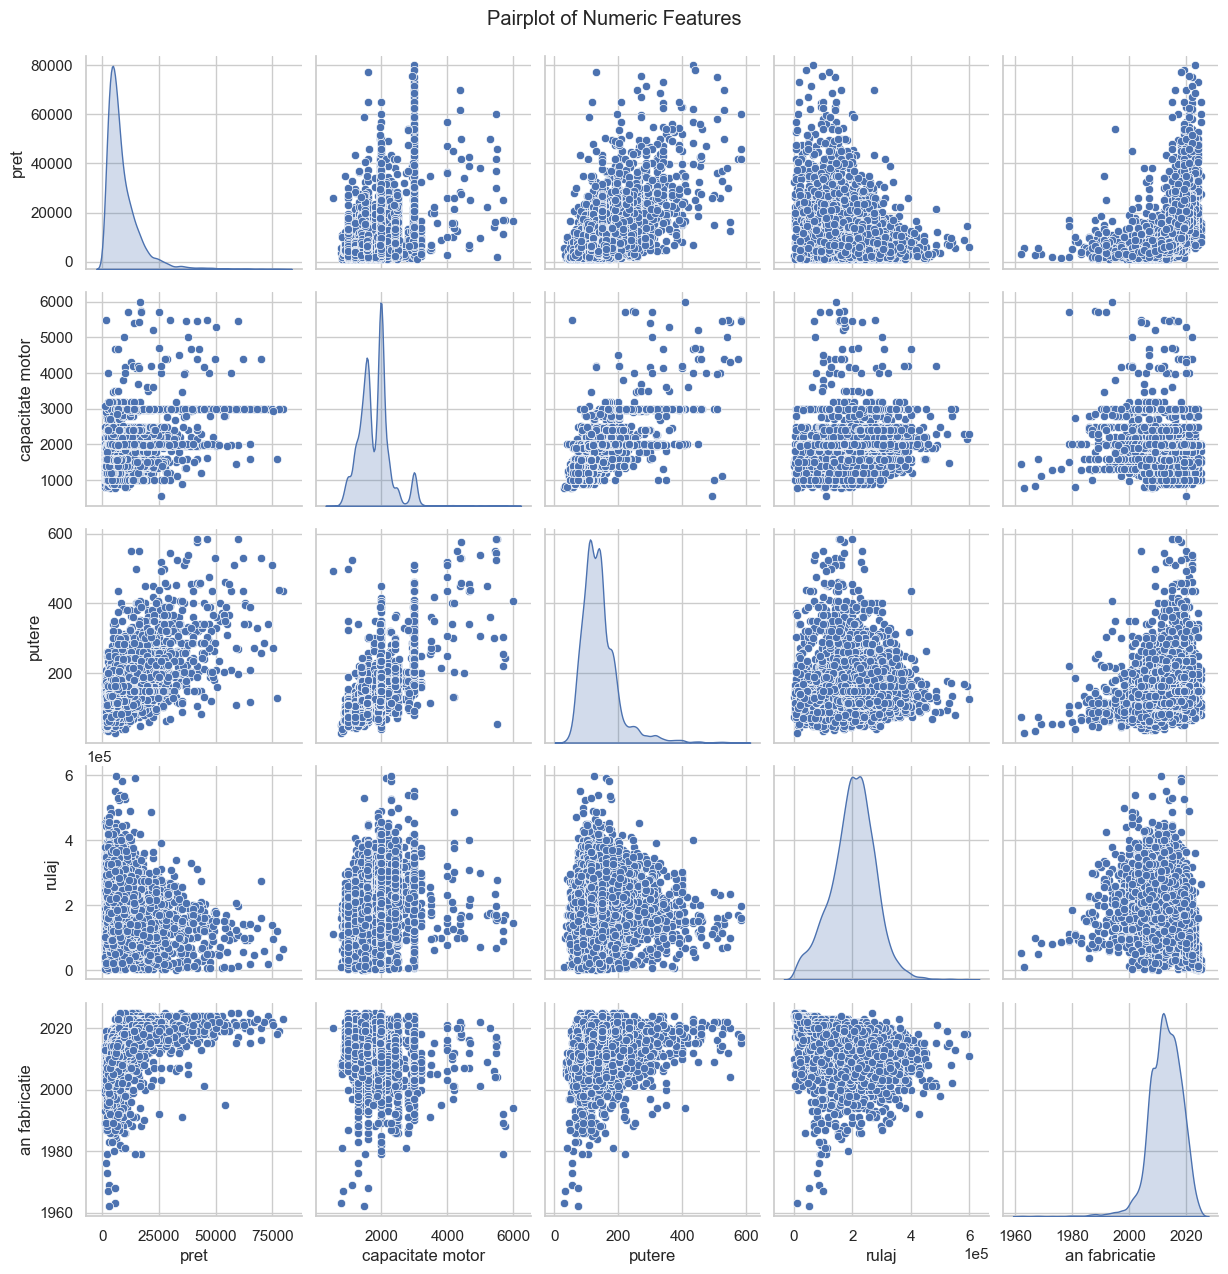

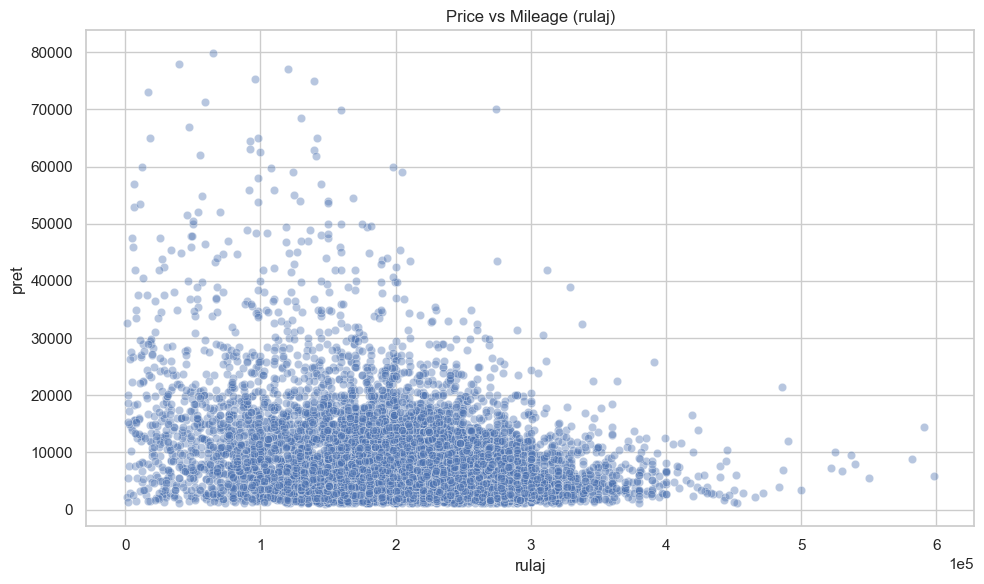

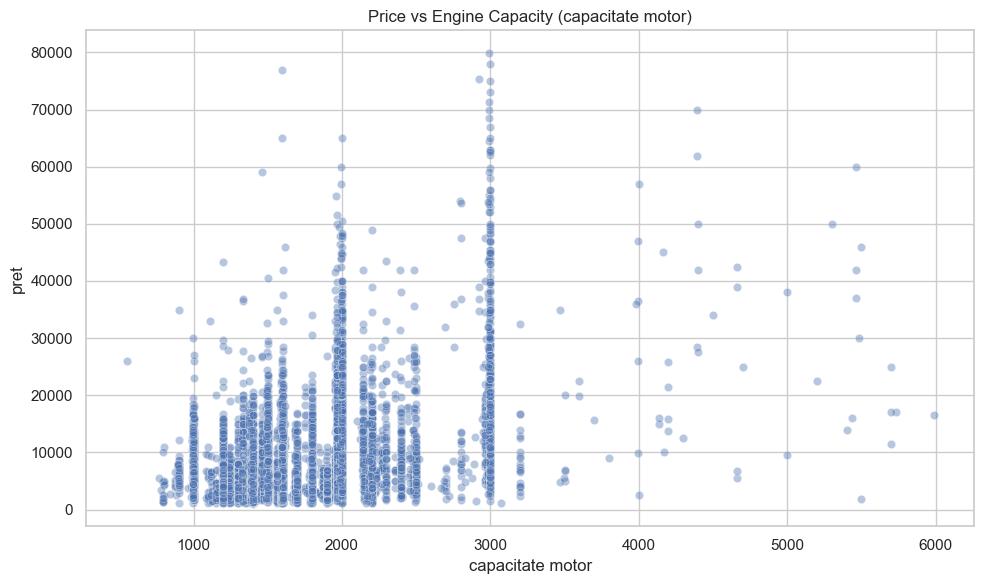

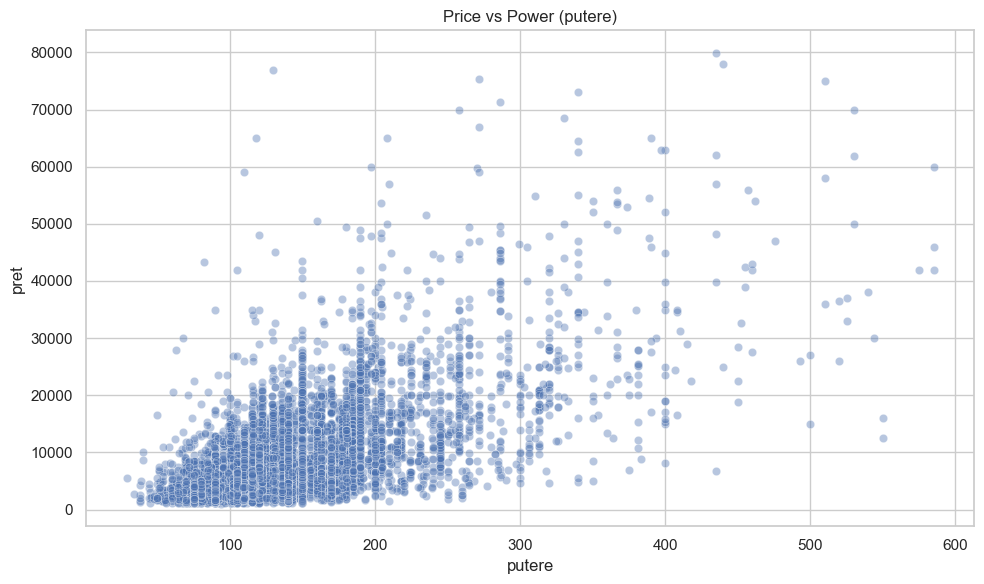

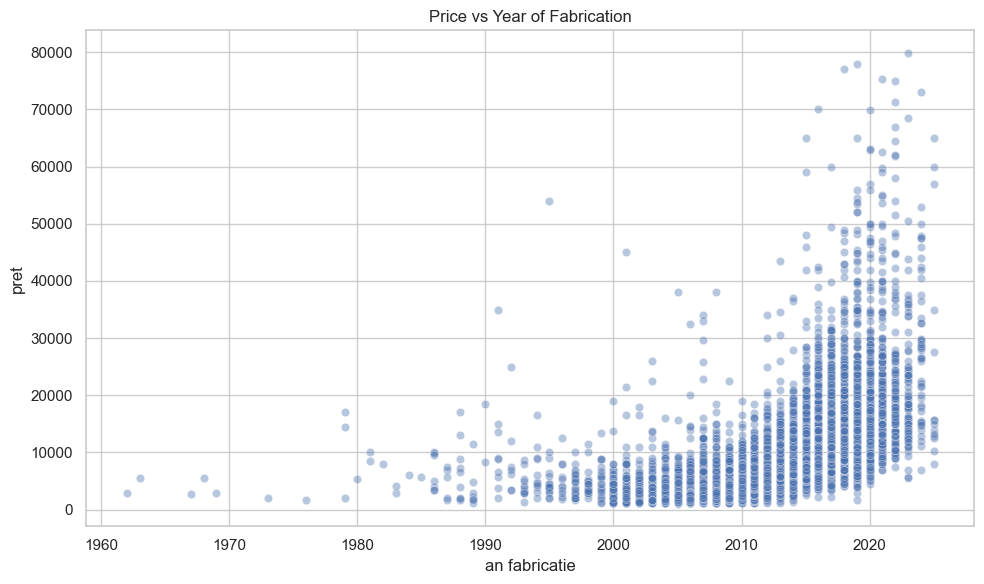

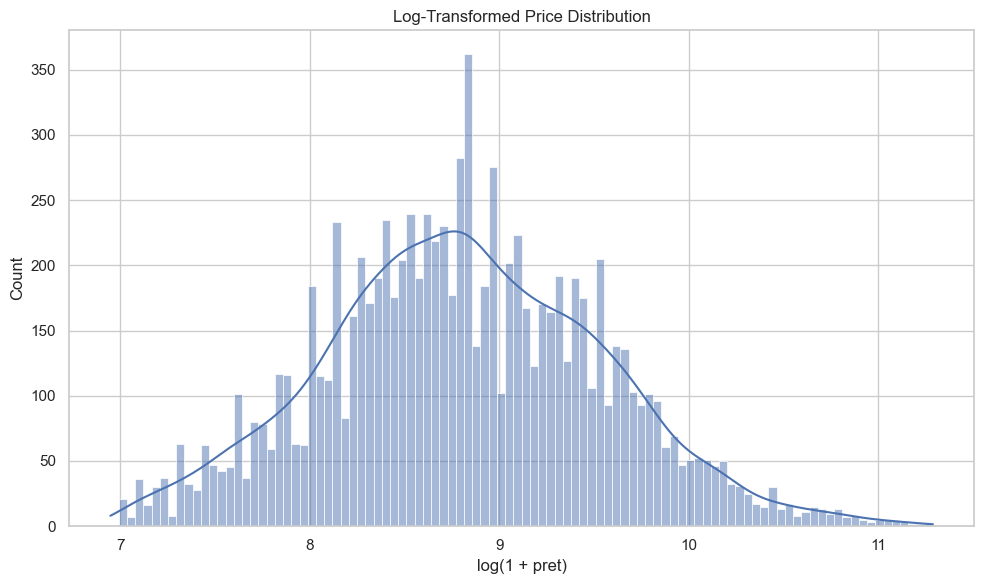

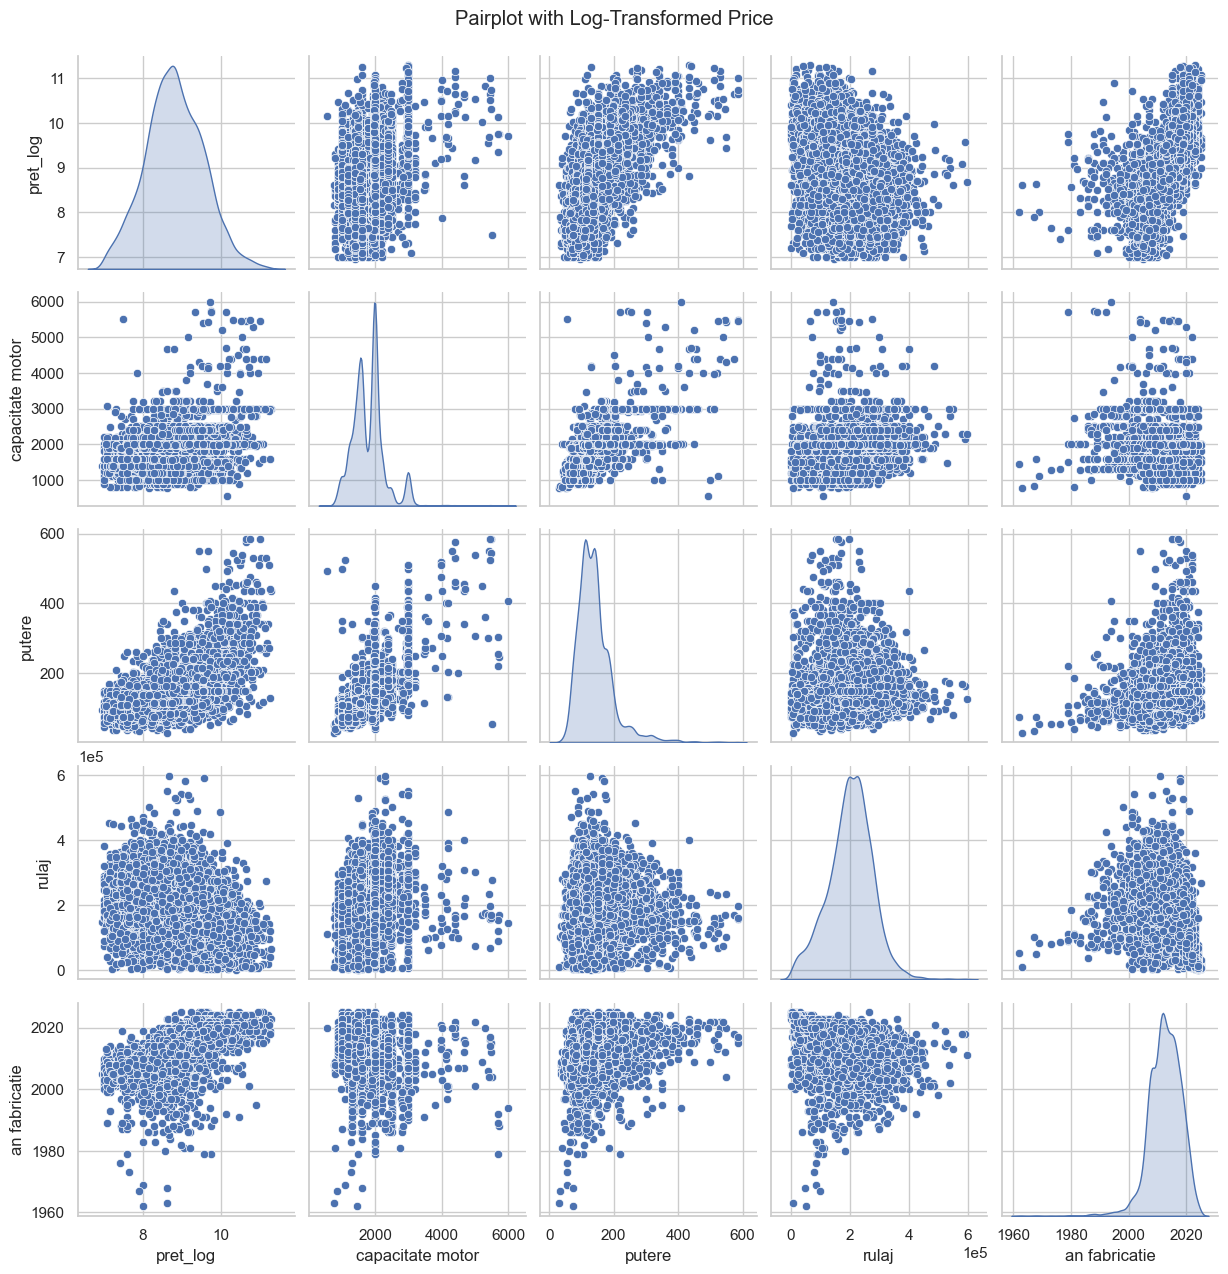

In [48]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd

# Global formatting for all plots
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['axes.formatter.limits'] = (0, 5)   # no sci-notation between 1 and 100 000

# =========================================================
# 0. PREP: CLEAN COPY + PLOT FOLDER
# =========================================================
PLOT_DIR = "plots/eda"
os.makedirs(PLOT_DIR, exist_ok=True)

# ensure price is numeric
df_clean['pret'] = pd.to_numeric(df_clean['pret'], errors='coerce')

# drop rows with missing price
df_clean = df_clean[df_clean['pret'].notna()]

numeric_cols = ['pret', 'capacitate motor', 'putere', 'rulaj', 'an fabricatie']
categorical_cols = ['marca','model','combustibil','caroserie','culoare','cutie viteza']


# helper to save + show plots
def save_and_show(name):
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, name), dpi=300, bbox_inches='tight')
    plt.show()


# =========================================================
# 1. BASIC INFO
# =========================================================
print("STRUCTURE:\n")
print(df_clean.info())

print("\nMISSING VALUES:\n")
print(df_clean.isnull().sum())

print("\nNUMERIC SUMMARY:\n")
print(df_clean[numeric_cols].describe())

print("\nCATEGORICAL SUMMARY:\n")
print(df_clean[categorical_cols].describe())

# =========================================================
# 2. DISTRIBUTION OF TARGET VARIABLE (pret)
# =========================================================
plt.figure(figsize=(12,8))
sns.histplot(df_clean['pret'], bins=100, kde=True)
plt.title("Distribution of Price (pret) with Density Curve")
plt.xlabel("pret")
plt.ylabel("Frequency")
save_and_show("01_pret_distribution.png")


# =========================================================
# 3. DISTRIBUTIONS OF NUMERIC FEATURES
# =========================================================
df_clean[numeric_cols].hist(figsize=(14,10), bins=50)
plt.suptitle("Numeric Feature Distributions")
save_and_show("02_numeric_histograms.png")


# =========================================================
# 4. BOXPLOTS FOR OUTLIERS
# =========================================================
plt.figure(figsize=(14,8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df_clean[col])
    plt.title(f'Outliers in {col}')
save_and_show("03_numeric_boxplots.png")


# =========================================================
# 5. CATEGORICAL FEATURE COUNTS
# =========================================================
for col in categorical_cols:
    plt.figure(figsize=(10,4))
    df_clean[col].value_counts().head(20).plot(kind='bar')
    plt.title(f"Top categories in {col}")
    plt.ylabel("Count")
    save_and_show(f"04_counts_{col}.png")


# =========================================================
# 6. PRICE vs CATEGORICAL FEATURES (boxplots)
# =========================================================
for col in categorical_cols:
    plt.figure(figsize=(12,6))
    sns.boxplot(data=df_clean, x=col, y='pret')
    plt.title(f"Price distribution by {col}")
    plt.xticks(rotation=90)
    save_and_show(f"05_price_by_{col}.png")


# =========================================================
# 7. CORRELATION MATRIX (NUMERIC ONLY)
# =========================================================
plt.figure(figsize=(10,6))
corr = df_clean[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
save_and_show("06_correlation_matrix.png")


# =========================================================
# 8. PAIRPLOT (RELATIONS BETWEEN NUMERIC FEATURES)
# =========================================================
pairplot_fig = sns.pairplot(df_clean[numeric_cols], diag_kind='kde')
pairplot_fig.fig.suptitle("Pairplot of Numeric Features", y=1.02)
pairplot_fig.fig.savefig(os.path.join(PLOT_DIR, "07_numeric_pairplot.png"),
                         dpi=300, bbox_inches='tight')
plt.show()


# =========================================================
# 9. RELATIONSHIPS WITH PRICE (SCATTERPLOTS)
# =========================================================
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_clean, x='rulaj', y='pret', alpha=0.4)
plt.title("Price vs Mileage (rulaj)")
save_and_show("08_price_vs_rulaj.png")

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_clean, x='capacitate motor', y='pret', alpha=0.4)
plt.title("Price vs Engine Capacity (capacitate motor)")
save_and_show("09_price_vs_capacitate_motor.png")

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_clean, x='putere', y='pret', alpha=0.4)
plt.title("Price vs Power (putere)")
save_and_show("10_price_vs_putere.png")

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_clean, x='an fabricatie', y='pret', alpha=0.4)
plt.title("Price vs Year of Fabrication")
save_and_show("11_price_vs_an_fabricatie.png")


# =========================================================
# 10. LOG-TRANSFORMED PRICE
# =========================================================
df_clean['pret_log'] = np.log1p(df_clean['pret'])

plt.figure(figsize=(10,6))
sns.histplot(df_clean['pret_log'], bins=100, kde=True)
plt.title("Log-Transformed Price Distribution")
plt.xlabel("log(1 + pret)")
save_and_show("12_pret_log_distribution.png")


# =========================================================
# 11. PAIRPLOT WITH LOG PRICE
# =========================================================
cols_log = ['pret_log','capacitate motor','putere','rulaj','an fabricatie']
pairplot_log_fig = sns.pairplot(df_clean[cols_log], diag_kind='kde')
pairplot_log_fig.fig.suptitle("Pairplot with Log-Transformed Price", y=1.02)
pairplot_log_fig.fig.savefig(os.path.join(PLOT_DIR, "13_pairplot_log_price.png"),
                             dpi=300, bbox_inches='tight')
plt.show()


- The distribution is strongly right-skewed. Most cars are in the lower price segment. High-priced cars exist but are increasingly rare as the price grows

- From numeric distribution we can categorize cars:
    - engine_size bins(0,1500,1500,1800,2000,3000,6000)
    - horsepower bin(0,100,150,200,300,1 000)
    - mileage bins(0,100 000, 200 000, 300 000, 800 000)
    - age groups bins (1950, 2000, 2005, 2010, 2015, 2020, 2025)

- Mark the outliers
    - Large engine flag. Detect engines bigger than 3.0L and smaller than 1.0L
    - High horsepower (supercar) flag Anything above 220 HP is abnormal for mainstream cars in the data set.
    - Very high mileage flag. Mileage above 350,000 km appears rarely.
    - Young / nearly new car flag. Cars newer than 2018 often have premium pricing.
    - Vintage / old car flag. Cars older than 1995 behave like collectibles.
- Brand categorization (premium / budget / standard)
    - Premium brands
        These consistently have higher prices across all segments.
        ['audi', 'bmw', 'mercedes-benz', 'volvo', 'tesla', 'porche']

    - Budget brands
    These have typically lower prices and target economy markets.
    ['dacia','skoda','fiat','renault','opel','suzuki','kia','hyundai','chevrolet','seat']

    - Standard / mid-tier brands
        Neither premium nor budget — average market pricing.
    ['citroen','ford','honda','mazda','mitsubishi','nissan','peugeot','toyota','volkswagen']
- Pairplot with log-price insights

    - Engine size, horsepower, mileage, and year all show strong relationships with log-price.

    - Year and horsepower have the clearest positive correlations.

    - Mileage has a strong negative correlation.

    - Engine size and horsepower are correlated with each other as well.

    - Log transformation clarifies these relationships and reveals cleaner trends.

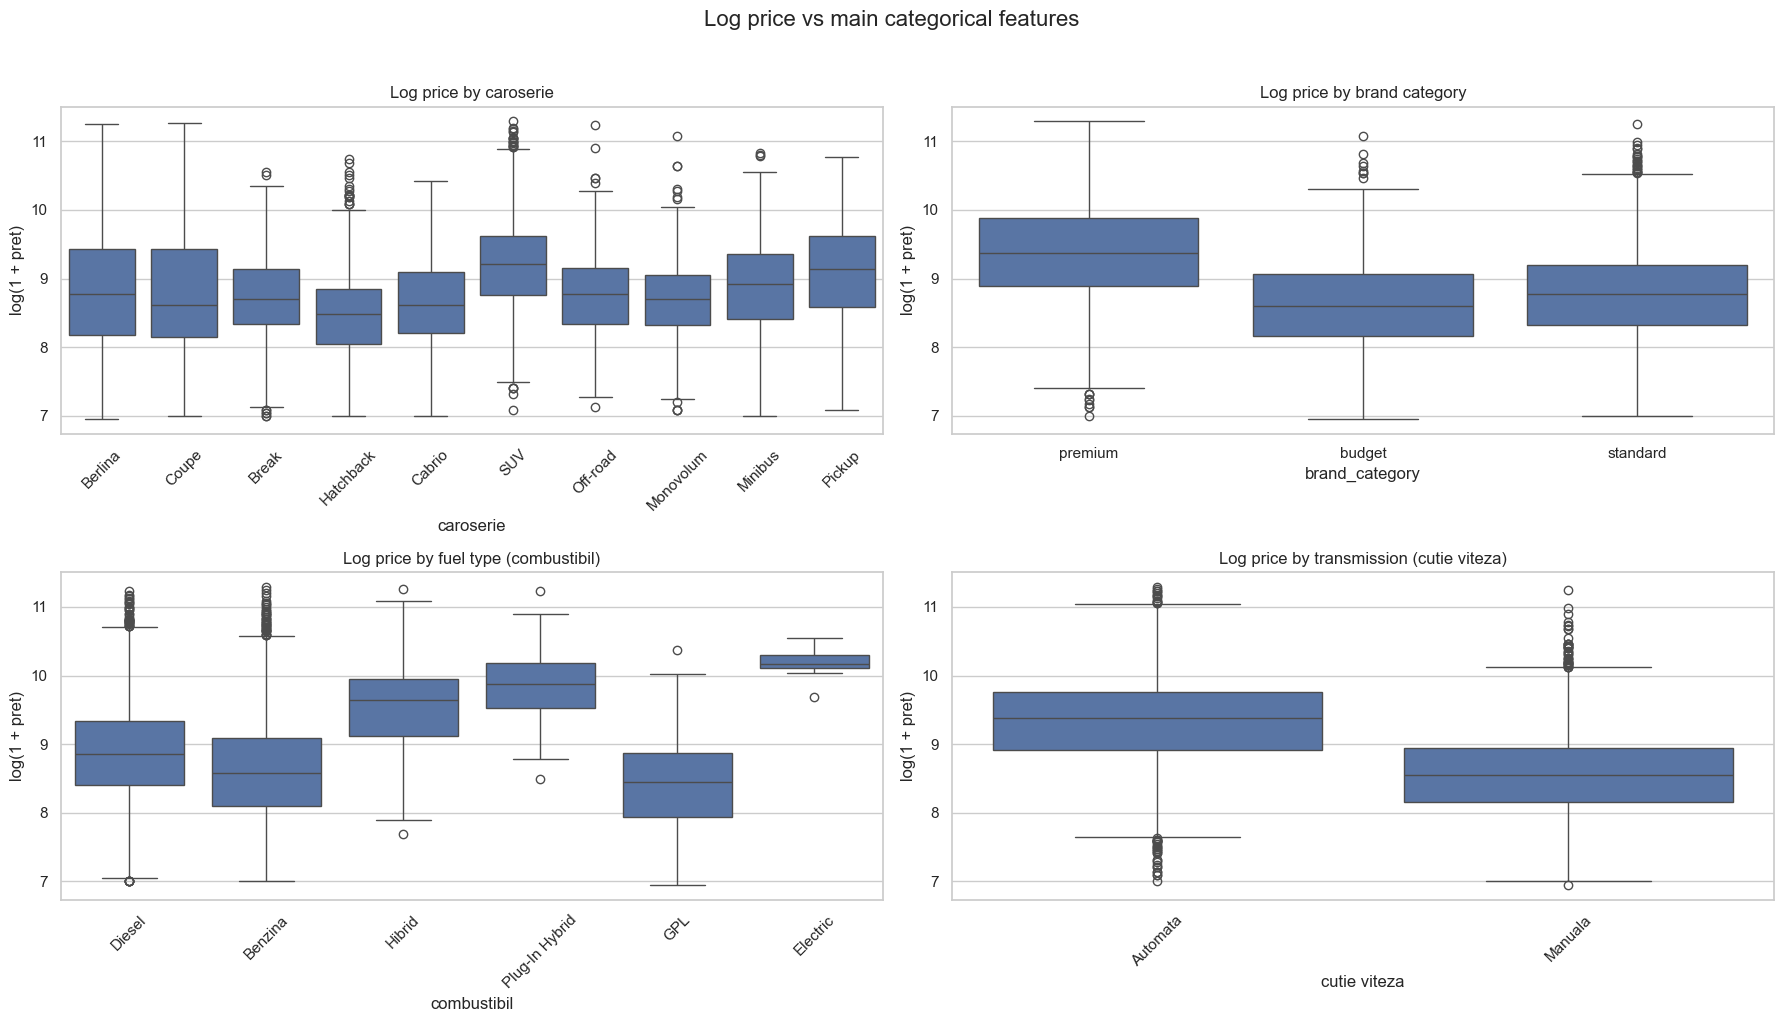

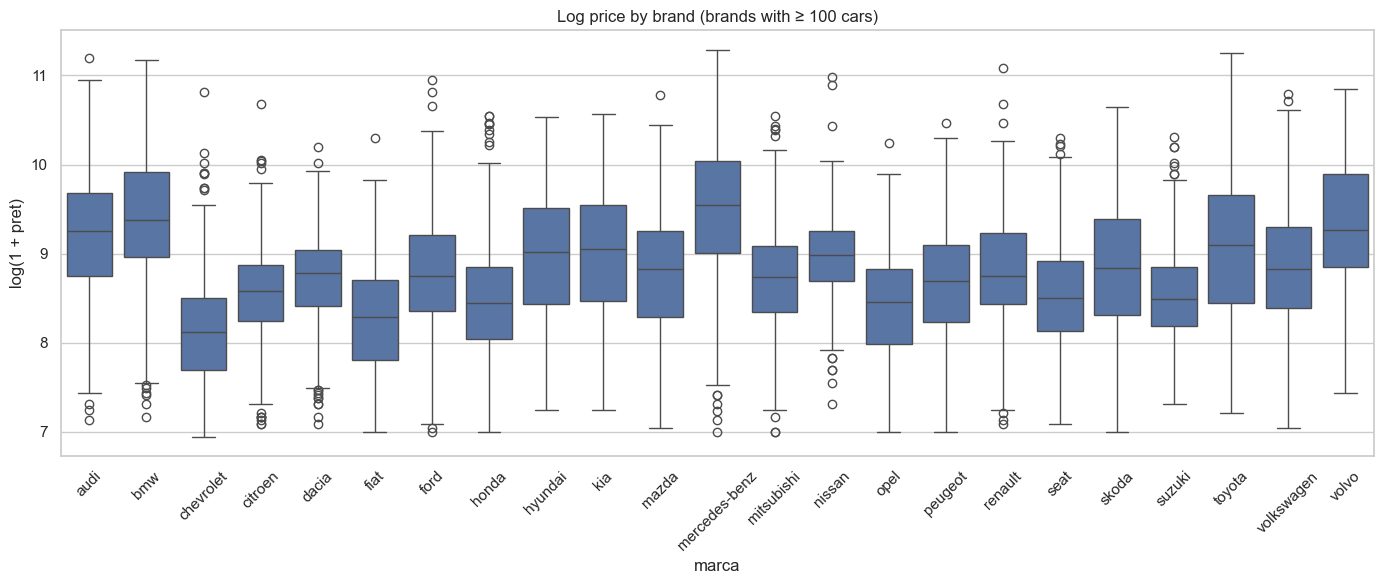

In [49]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ------------------------------------------------------------------
# 0. Ensure output folder + brand_category exists
# ------------------------------------------------------------------
PLOT_DIR = "plots/eda"
os.makedirs(PLOT_DIR, exist_ok=True)

premium_brands = ["audi","bmw","mercedes-benz","volvo","tesla","porche"]
budget_brands  = ["dacia","skoda","fiat","renault","opel",
                  "suzuki","kia","hyundai","chevrolet","seat"]

def brand_category(marca):
    if marca in premium_brands:
        return "premium"
    elif marca in budget_brands:
        return "budget"
    else:
        return "standard"

if "brand_category" not in df_clean.columns:
    df_clean["brand_category"] = df_clean["marca"].str.lower().apply(brand_category)

# ------------------------------------------------------------------
# 1. One figure with multiple subplots (log price vs main categories)
# ------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.ravel()

# (a) caroserie
sns.boxplot(
    data=df_clean,
    x="caroserie",
    y="pret_log",
    ax=axes[0]
)
axes[0].set_title("Log price by caroserie")
axes[0].set_xlabel("caroserie")
axes[0].set_ylabel("log(1 + pret)")
axes[0].tick_params(axis='x', rotation=45)

# (b) brand_category
sns.boxplot(
    data=df_clean,
    x="brand_category",
    y="pret_log",
    ax=axes[1]
)
axes[1].set_title("Log price by brand category")
axes[1].set_xlabel("brand_category")
axes[1].set_ylabel("log(1 + pret)")

# (c) combustibil
sns.boxplot(
    data=df_clean,
    x="combustibil",
    y="pret_log",
    ax=axes[2]
)
axes[2].set_title("Log price by fuel type (combustibil)")
axes[2].set_xlabel("combustibil")
axes[2].set_ylabel("log(1 + pret)")
axes[2].tick_params(axis='x', rotation=45)

# (d) cutie viteza
sns.boxplot(
    data=df_clean,
    x="cutie viteza",
    y="pret_log",
    ax=axes[3]
)
axes[3].set_title("Log price by transmission (cutie viteza)")
axes[3].set_xlabel("cutie viteza")
axes[3].set_ylabel("log(1 + pret)")
axes[3].tick_params(axis='x', rotation=45)

fig.suptitle("Log price vs main categorical features", y=1.02, fontsize=16)
fig.tight_layout()
fig.savefig(os.path.join(PLOT_DIR, "log_price_by_main_categories.png"),
            dpi=300, bbox_inches="tight")

plt.show()

# ------------------------------------------------------------------
# 2. Separate figure: log price by brand (only common brands)
# ------------------------------------------------------------------
# keep brands with at least N listings, e.g. 100
min_count = 100
common_brands = (
    df_clean["marca"].value_counts()
      .loc[lambda s: s >= min_count]
      .index
)

fig2, ax2 = plt.subplots(figsize=(14, 6))
sns.boxplot(
    data=df_clean[df_clean["marca"].isin(common_brands)],
    x="marca",
    y="pret_log",
    ax=ax2
)
ax2.set_title(f"Log price by brand (brands with ≥ {min_count} cars)")
ax2.set_xlabel("marca")
ax2.set_ylabel("log(1 + pret)")
ax2.tick_params(axis='x', rotation=45)

fig2.tight_layout()
fig2.savefig(os.path.join(PLOT_DIR, "log_price_by_brand_common.png"),
             dpi=300, bbox_inches="tight")

plt.show()


<Axes: xlabel='an fabricatie', ylabel='putere'>

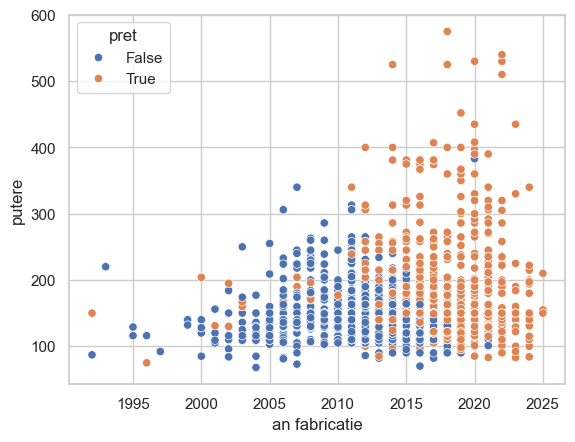

In [50]:
def get_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    return df[df[column] > upper]
outliers_caroserie = {}

for c in df_clean["caroserie"].unique():
    subset = df_clean[df_clean["caroserie"] == c]
    outliers_caroserie[c] = get_outliers(subset, "pret")
def explain_outliers(df, category_column):
    results = {}

    for c in df[category_column].unique():
        sub = df[df[category_column] == c]
        outs = get_outliers(sub, "pret")

        if len(outs) == 0:
            continue

        compare = outs[["an fabricatie","rulaj","putere","capacitate motor"]].mean().round(0)
        compare["count"] = len(outs)
        results[c] = compare

    return pd.DataFrame(results).T

sns.scatterplot(
    data=df_clean[df_clean["caroserie"] == "SUV"],
    x="an fabricatie",
    y="putere",
    hue=df_clean["pret"] > df_clean["pret"].quantile(0.75)
)


- Model has very high cardinality (hundreds of unique values).
    - To reduce noise and avoid overfitting, models appearing fewer than 50 times will grouped into a new category "unknown".
    - This preserves strong model-specific signals while preventing rare categories from destabilizing the model.
- Insights from Outlier Comparison (Price Outliers vs Normal Cars)

    - After visualizing price outliers in relation to engine power and manufacturing year, we observe the following:

    - Price outliers are mostly newer cars (post-2015), confirming that age (year of fabrication) is a strong non-linear predictor of price.

    - Outliers also tend to have high horsepower, often above 200–250 HP.

    - These two characteristics combined (new + powerful engine) explain most of the “unexpectedly expensive” points.

    - Some older cars also appear as “expensive” outliers — these are likely collector cars, confirming that age alone is not enough; the interaction between old car + high power + rare model may create special cases.
    - To help the model correctly learn these patterns and avoid mispredicting high-value cars:

        - Add a “new_car_flag” feature: 1 if year >= 2018
        - (captures modern cars with premium pricing)

        - Add a “high_power_flag” feature: 1 if HP > 200
        - (captures sport / premium engines)

        - Add an “old_collectible_flag” feature: 1 if year < 1995 AND HP > 150
        - captures vintage performance cars

In [51]:
df_clean.sample(5)

,marca,model,pret,capacitate motor,putere,combustibil,caroserie,rulaj,culoare,an fabricatie,cutie viteza,pret_log,brand_category
5961,mercedes-benz,E Class,25500.0,1950,195,Diesel,Coupe,245000,Negru,2018,Automata,10.146473,premium
6165,mercedes-benz,E Class,8500.0,2200,170,Diesel,Berlina,290000,Gri,2012,Automata,9.047939,premium
8743,renault,Megane,4700.0,1500,110,NaN,Coupe,149000,Albastru,2011,Manuala,8.455531,budget
7997,peugeot,308,6600.0,1600,90,Diesel,Berlina,150200,Negru,2017,Manuala,8.794976,standard
3161,fiat,Freemont,5750.0,1956,140,Diesel,SUV,233085,Gri,2013,Manuala,8.657129,budget


## Feature Engineering

In this section we transform the raw scraped data into a training-ready dataset:

- Bin numeric variables:
  - `engine_size_bin` (engine capacity ranges)
  - `hp_bin` (horsepower ranges)
  - `mileage_bin` (kilometre ranges)
  - `age_bin` (fabrication year ranges)
- Create outlier / non-linear flags:
  - `large_engine_flag`, `small_engine_flag`
  - `high_hp_flag`, `high_mileage_flag`
  - `new_car_flag`, `vintage_flag`
- Build brand and body-type categories:
  - `brand_category` (premium / budget / standard)
  - `model_simplified` (rare models → "UNKNOWN")
  - `is_suv`, `is_sport_body`, `is_large_body`
  - `is_electric`, `is_hybrid`
- Add interaction-style flags discovered from EDA:
  - `new_and_powerful`
  - `old_collectible`
- Prepare the final training dataframe `df_train`, which keeps:
  - target: `pret_log`
  - core numeric features
  - categorical features and engineered flags

The column `is_price_outlier` is kept only for analysis and is **not** used as a training feature to avoid target leakage.


In [52]:
import pandas as pd
import numpy as np

df_fe = df_clean.copy()

# ============================================================
# 0. HANDLE MISSING VALUES STRATEGICALLY
# ============================================================

# For combustibil: fill with mode or create "Unknown" category
df_fe["combustibil"] = df_fe["combustibil"].fillna("Unknown")

# For cutie viteza: fill with mode or create "Unknown" category
df_fe["cutie viteza"] = df_fe["cutie viteza"].fillna(df_fe["cutie viteza"].mode()[0])

# For culoare: fill with mode
df_fe["culoare"] = df_fe["culoare"].fillna(df_fe["culoare"].mode()[0])


# ============================================================
# 1. NUMERIC BINNING (WITH IMPROVEMENTS)
# ============================================================

# 1.1 Engine size bins
df_fe["engine_size_bin"] = pd.cut(
    df_fe["capacitate motor"],
    bins=[0, 1500, 1800, 2000, 3000, 6000],
    labels=["<1500", "1500–1800", "1800–2000", "2000–3000", ">3000"],
    include_lowest=True
)

# 1.2 Horsepower bins
df_fe["hp_bin"] = pd.cut(
    df_fe["putere"],
    bins=[0, 100, 150, 200, 300, 1000],
    labels=["<100", "100–150", "150–200", "200–300", ">300"],
    include_lowest=True
)

# 1.3 Mileage bins
df_fe["mileage_bin"] = pd.cut(
    df_fe["rulaj"],
    bins=[0, 100000, 200000, 300000, 800000],
    labels=["<100k", "100–200k", "200–300k", ">300k"],
    include_lowest=True
)

# 1.4 Age bins - more granular for recent cars
df_fe["age_bin"] = pd.cut(
    df_fe["an fabricatie"],
    bins=[1950, 2000, 2005, 2010, 2015, 2018, 2020, 2025],
    labels=["1950–2000", "2000–2005", "2005–2010", "2010–2015", "2015–2018", "2018–2020", "2020–2025"],
    include_lowest=True
)

# 1.5 Continuous age feature
df_fe["age_years"] = 2024 - df_fe["an fabricatie"]


# ============================================================
# 2. OUTLIER FLAGS
# ============================================================

df_fe["large_engine_flag"] = (df_fe["capacitate motor"] > 3000).astype(int)
df_fe["small_engine_flag"] = (df_fe["capacitate motor"] < 1000).astype(int)

df_fe["high_hp_flag"] = (df_fe["putere"] > 220).astype(int)
df_fe["low_hp_flag"] = (df_fe["putere"] < 50).astype(int)

df_fe["high_mileage_flag"] = (df_fe["rulaj"] > 350000).astype(int)
df_fe["low_mileage_flag"] = (df_fe["rulaj"] < 5000).astype(int)

df_fe["new_car_flag"] = (df_fe["an fabricatie"] >= 2018).astype(int)
df_fe["vintage_flag"] = (df_fe["an fabricatie"] < 1995).astype(int)


# ============================================================
# 3. ERA STRATIFICATION (based on market/engineering shifts)
# ============================================================

def assign_era(year):
    if year < 1995:
        return "vintage"
    elif year < 2005:
        return "older_standard"
    elif year < 2010:
        return "mid_standard"
    elif year < 2015:
        return "modern_early"
    else:
        return "modern_recent"

df_fe["car_era"] = df_fe["an fabricatie"].apply(assign_era)

# One-hot encode eras
era_dummies = pd.get_dummies(df_fe["car_era"], prefix="era", drop_first=False)
df_fe = pd.concat([df_fe, era_dummies], axis=1)
df_fe = df_fe.reset_index(drop=True)  # Reset index to avoid alignment issues


# ============================================================
# 4. BRAND CATEGORY (PREMIUM / BUDGET / STANDARD)
# ============================================================

premium_brands  = ['audi', 'bmw', 'mercedes-benz', 'volvo', 'tesla', 'porche', 'lamborghini', 'jaguar']
budget_brands   = ['dacia', 'skoda', 'fiat', 'renault', 'opel', 'suzuki', 'kia', 'hyundai', 'chevrolet', 'seat']
standard_brands = ['citroen', 'ford', 'honda', 'mazda', 'mitsubishi', 'nissan', 'peugeot', 'toyota', 'volkswagen']

df_fe["brand_category"] = "standard"
df_fe.loc[df_fe["marca"].isin(premium_brands), "brand_category"] = "premium"
df_fe.loc[df_fe["marca"].isin(budget_brands),  "brand_category"] = "budget"

# One-hot encode brand categories
brand_dummies = pd.get_dummies(df_fe["brand_category"], prefix="brand", drop_first=False)
df_fe = pd.concat([df_fe, brand_dummies], axis=1)
df_fe = df_fe.reset_index(drop=True)  # Reset index to avoid alignment issues

df_fe["is_premium_brand"] = (df_fe["brand_category"] == "premium").astype(int)
df_fe["is_budget_brand"]  = (df_fe["brand_category"] == "budget").astype(int)


# ============================================================
# 5. MODEL SIMPLIFICATION & FREQUENCY ENCODING
# ============================================================

model_counts = df_fe["model"].value_counts()
rare_models = model_counts[model_counts < 50].index

df_fe["model_simplified"] = df_fe["model"].where(~df_fe["model"].isin(rare_models), "UNKNOWN")

# Model frequency encoding (how common is this model)
df_fe["model_frequency"] = df_fe["model"].map(model_counts)
#df_fe.loc[df_fe["model"].isin(rare_models), "model_frequency"] = model_counts[model_counts < 50].mean()


# ============================================================
# 6. CAROSERIE & FUEL TYPE FLAGS
# ============================================================

# Caroserie-based flags
df_fe["is_suv"] = (df_fe["caroserie"] == "SUV").astype(int)
df_fe["is_sport_body"] = df_fe["caroserie"].isin(["Coupe", "Cabrio"]).astype(int)
df_fe["is_large_body"] = df_fe["caroserie"].isin(["SUV", "Pickup", "Minibus", "Monovolum"]).astype(int)
df_fe["is_sedan"] = df_fe["caroserie"].isin(["Sedan", "Berlina"]).astype(int)

# Fuel type flags
df_fe["is_electric"] = (df_fe["combustibil"] == "Electric").astype(int)
df_fe["is_hybrid"]   = df_fe["combustibil"].isin(["Hybrid", "Plug-in Hybrid"]).astype(int)
df_fe["is_diesel"] = (df_fe["combustibil"] == "Diesel").astype(int)
df_fe["is_petrol"] = (df_fe["combustibil"] == "Benzina").astype(int)

# Transmission type
df_fe["is_automatic"] = df_fe["cutie viteza"].isin(["Automata", "Automatic"]).astype(int)
df_fe["is_manual"] = (df_fe["cutie viteza"] == "Manuala").astype(int)


# ============================================================
# 7. COLOR ENCODING
# ============================================================

# Group rare colors
color_counts = df_fe["culoare"].value_counts()
rare_colors = color_counts[color_counts < 100].index
df_fe["culoare_simplified"] = df_fe["culoare"].where(~df_fe["culoare"].isin(rare_colors), "Other")

# One-hot encode popular colors
popular_colors = color_counts[color_counts >= 100].index
for color in popular_colors:
    col_name = f"color_{color.lower().replace(' ', '_')}"
    df_fe[col_name] = (df_fe["culoare"] == color).astype(int)


# ============================================================
# 8. RATIO & DERIVED FEATURES
# ============================================================

# Power-to-displacement ratio (efficiency/performance indicator)
df_fe["power_to_displacement"] = df_fe["putere"] / (df_fe["capacitate motor"] / 1000)

# Power per liter (specific output)
df_fe["power_per_liter"] = df_fe["putere"] / (df_fe["capacitate motor"] / 1000)

# Mileage per year (usage intensity)
df_fe["mileage_per_year"] = df_fe["rulaj"] / (df_fe["age_years"] + 1)

# Engine efficiency flag (smaller engine with decent power)
df_fe["engine_efficiency_flag"] = (
    (df_fe["capacitate motor"] < 1500) & 
    (df_fe["putere"] >= 100)
).astype(int)


# ============================================================
# 9. DATA QUALITY & ANOMALY FLAGS
# ============================================================

# Recent eco-cars (new + low power, likely real data)
df_fe["eco_recent"] = (
    (df_fe["an fabricatie"] >= 2015) & 
    (df_fe["putere"] < 50)
).astype(int)

# ============================================================
# 10. INTERACTION FLAGS (SPECIAL SEGMENTS)
# ============================================================

# New + powerful (common expensive outliers)
df_fe["new_and_powerful"] = ((df_fe["an fabricatie"] >= 2018) & (df_fe["putere"] > 200)).astype(int)

# Vintage + powerful (collectible potential)
df_fe["old_collectible"] = ((df_fe["an fabricatie"] < 1995) & (df_fe["putere"] > 150)).astype(int)

# High mileage + old (depreciation risk)
df_fe["high_mileage_old"] = ((df_fe["rulaj"] > 300000) & (df_fe["an fabricatie"] < 2010)).astype(int)

# Premium + new (expensive segment)
df_fe["premium_new"] = ((df_fe["is_premium_brand"] == 1) & (df_fe["an fabricatie"] >= 2018)).astype(int)

# Budget + new (affordable recent cars)
df_fe["budget_new"] = ((df_fe["is_budget_brand"] == 1) & (df_fe["an fabricatie"] >= 2018)).astype(int)

# SUV + recent + automatic (popular segment)
df_fe["modern_suv_auto"] = ((df_fe["is_suv"] == 1) & (df_fe["an fabricatie"] >= 2015) & (df_fe["is_automatic"] == 1)).astype(int)


# ============================================================
# 11. LOG TRANSFORMATIONS (for skewed features)
# ============================================================

# Log price (helps with skewed price distributions in linear models)

# Log mileage
df_fe["log_mileage"] = np.log1p(df_fe["rulaj"])

# Log engine size
df_fe["log_engine_size"] = np.log1p(df_fe["capacitate motor"])


df_fe.head()

,marca,model,pret,capacitate motor,putere,combustibil,caroserie,rulaj,culoare,an fabricatie,...,engine_efficiency_flag,eco_recent,new_and_powerful,old_collectible,high_mileage_old,premium_new,budget_new,modern_suv_auto,log_mileage,log_engine_size
0,audi,A8,5800.0,3000,232,Diesel,Berlina,340000,Albastru,2007,...,0,0,0,0,1,0,0,0,12.736704,8.006701
1,audi,TT,6990.0,1998,170,Diesel,Coupe,245000,Negru,2009,...,0,0,0,0,0,0,0,0,12.409018,7.600402
2,audi,A4,9900.0,1968,177,Diesel,Break,238200,Alb,2014,...,0,0,0,0,0,0,0,0,12.380870,7.585281
3,audi,A6,3490.0,1998,177,Diesel,Berlina,150000,Gri,2011,...,0,0,0,0,0,0,0,0,11.918397,7.600402
4,audi,TT,8450.0,1968,170,Diesel,Coupe,238000,Albastru,2008,...,0,0,0,0,0,0,0,0,12.380030,7.585281


In [53]:
import os
import numpy as np

# Ensure log price exists
if "pret_log" not in df_fe.columns:
    df_fe["pret_log"] = np.log1p(df_fe["pret"])

target_col = "pret_log"

# Base numeric features
base_numeric = [
    "capacitate motor",
    "putere",
    "rulaj",
    "an fabricatie",
    "age_years",
]

# Categorical features
categorical_core = [
    "marca",
    "brand_category",
    "model_simplified",
    "caroserie",
    "combustibil",
    "cutie viteza",
    "car_era",
]

# Binned features
binned_cols = [
    "engine_size_bin",
    "hp_bin",
    "mileage_bin",
    "age_bin",
]

# Flag features
flag_cols = [
    "large_engine_flag",
    "small_engine_flag",
    "high_hp_flag",
    "low_hp_flag",
    "high_mileage_flag",
    "low_mileage_flag",
    "new_car_flag",
    "vintage_flag",
    "is_premium_brand",
    "is_budget_brand",
    "is_suv",
    "is_sport_body",
    "is_large_body",
    "is_sedan",
    "is_electric",
    "is_hybrid",
    "is_diesel",
    "is_petrol",
    "is_automatic",
    "is_manual",
    "engine_efficiency_flag",
    "new_and_powerful",
    "old_collectible",
    "high_mileage_old",
    "premium_new",
    "budget_new",
    "modern_suv_auto",
    "eco_recent",
]

# One-hot encoded features
era_cols = [col for col in df_fe.columns if col.startswith("era_")]
brand_cols = [col for col in df_fe.columns if col.startswith("brand_")]
color_cols = [col for col in df_fe.columns if col.startswith("color_")]

# Ratio and log features
ratio_cols = [
    "power_to_displacement",
    "power_per_liter",
    "mileage_per_year",
    "model_frequency",
]

log_cols = [
    "log_mileage",
    "log_engine_size",
]

# Combine all features
all_feature_cols = (
    base_numeric + categorical_core + binned_cols + flag_cols + 
    era_cols + brand_cols + color_cols + ratio_cols + log_cols
)

# Filter to only existing columns
all_feature_cols = [col for col in all_feature_cols if col in df_fe.columns]

# ============================================================
# CREATE & CLEAN DATASET
# ============================================================

df_train = df_fe[all_feature_cols + [target_col]].copy()

# Replace infinities with NaN
df_train = df_train.replace([np.inf, -np.inf], np.nan)

# Fill all NaNs
df_train = df_train.fillna(df_train.median(numeric_only=True))
#for col in df_train.select_dtypes(include=['object']).columns:
#    df_train[col] = df_train[col].fillna(df_train[col].mode()[0] if len(df_train[col].mode()) > 0 else "Unknown")

# ============================================================
# SAVE
# ============================================================

os.makedirs("data/processed", exist_ok=True)
print(df_train.isnull().sum())
df_train.to_csv("data/processed/train_ready.csv", index=False)
print(f"✓ Saved {df_train.shape[0]} rows × {df_train.shape[1]} features")
print(f"  File: data/processed/train_ready.csv")

capacitate motor    0
putere              0
rulaj               0
an fabricatie       0
age_years           0
                   ..
mileage_per_year    0
model_frequency     0
log_mileage         0
log_engine_size     0
pret_log            0
Length: 69, dtype: int64
✓ Saved 9423 rows × 69 features
  File: data/processed/train_ready.csv


- 